# Using Jina Reader to Read an Entire Website for Check Grounding

> [Han@Jina AI](https://x.com/hxiao)

This notebook is mainly inspired by [Bo's tweet](https://x.com/bo_wangbo/status/1790652664742572500) about using [Jina Reader](https://jina.ai/reader) to follow a website's `sitemap.xml` for **check grounding**.

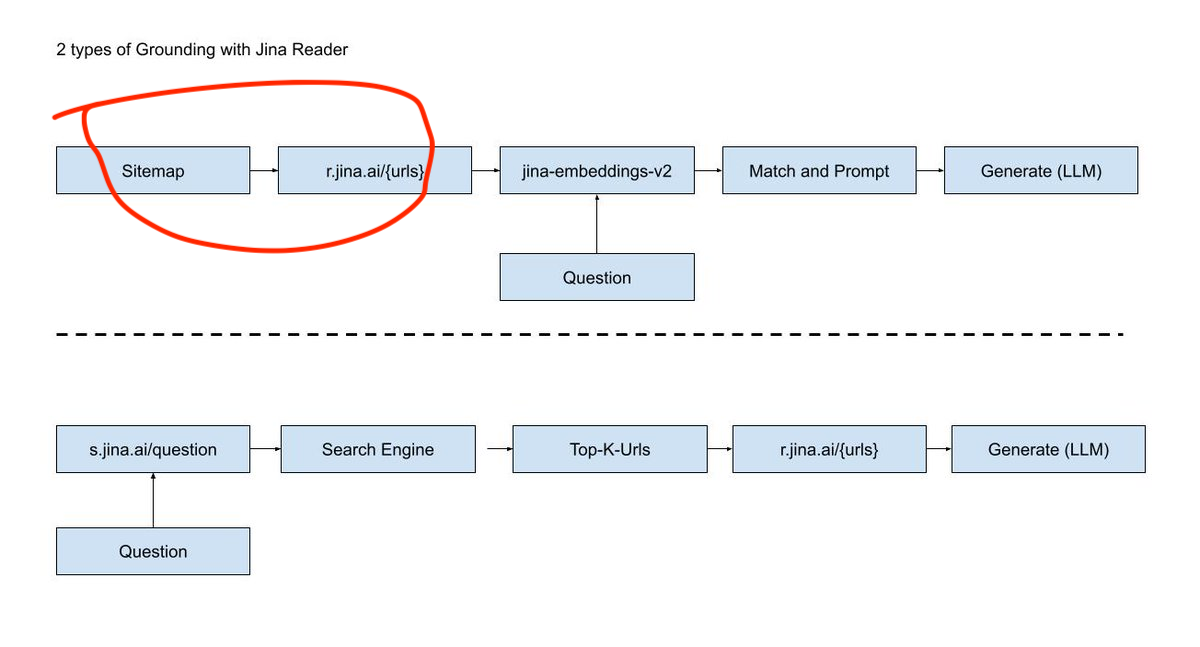

Fetching a single webpage is easy, but fetching multiple pages or even an entire site? A simple for-loop is straightforward but not necessarily the most efficient method. What about running a full batch of parallel requests to the Reader API? Well, you'll hit the rate limit in no time.

This notebook serves as a great example, demonstrating how to use `asyncio` and `Semaphore` to efficiently query the Reader API. Get what you need without hitting the rate limit.

In [ ]:
!pip install aiofiles
!pip install nest_asyncio

We will use async inside notebook, which requires some tweaks below.

In [ ]:
import aiohttp
import asyncio
import aiofiles
import xml.etree.ElementTree as ET
import json
import nest_asyncio

nest_asyncio.apply()
progress_lock = asyncio.Lock()

Next we define three auxliary functions:

- `fetch(session, url, headers, semaphore)`: Fetches a URL with specified headers, ensuring proper content type, within the semaphore limit.

- `fetch_content(session, url, semaphore, progress, total, api_key=None)`: Fetches content from a URL in HTML, markdown, and default format, updating progress accordingly.

- `fetch_sitemap_urls(sitemap_url)`: Retrieves all URLs listed in a sitemap XML from the given sitemap URL.

Finally, `fetch_all_content(sitemap_url, api_key)`: **This is our main entrypoint.** Fetches and processes content from all URLs in a sitemap, saving the results to a JSON file with the format below:

```json
[
{"html": ...,
 "markdown": ...,
 "default": ...
}
]


In [ ]:
from ast import NodeTransformer
async def fetch(session, url, headers, semaphore):
    async with semaphore:
        async with session.get(url, headers=headers) as response:
            response.raise_for_status()  # Ensure we raise an error for bad responses
            if 'application/json' in response.headers.get('Content-Type'):
                return await response.json()
            else:
                raise aiohttp.ContentTypeError(
                    request_info=response.request_info,
                    history=response.history,
                    message=f"Unexpected content type: {response.headers.get('Content-Type')}"
                )

async def fetch_content(session, url, semaphore, progress, total, api_key):
    headers_common = {
        "Accept": "application/json",
    }

    if api_key:
      headers_common["Authorization"] = f"Bearer {api_key}"

    headers_html = headers_common.copy()
    headers_html["X-Return-Format"] = "html"

    headers_markdown = headers_common.copy()
    headers_markdown["X-Return-Format"] = "markdown"

    try:
        url1 = f"https://r.jina.ai/{url}"

        # full html before the filtering pipeline, consume MOST tokens!
        # comment this out if u dont need it!
        response_html = fetch(session, url1, headers_html, semaphore)

        # html->markdown but without smart filtering
        # comment this out if u dont need it!
        response_markdown = fetch(session, url1, headers_markdown, semaphore)

        # default content behavior as if u access via https://r.jina.ai/url
        # comment this out if u dont need it!
        response_default = fetch(session, url1, headers_common, semaphore)

        html, markdown, default = await asyncio.gather(response_html, response_markdown, response_default)

        result = {
            'url': url,
            'default': default.get('data').get('content'),
            'html': html.get('data').get('html'),
            'markdown': markdown.get('data').get('content'),
        }
    except aiohttp.ContentTypeError as e:
        print(f"Skipping URL due to content type error: {url}")
        result = {
            'url': url,
            'default': None,
            'html': None,
            'markdown': None,
        }

    async with progress_lock:
        progress['completed'] += 1
        print(f"Completed {progress['completed']} out of {total} requests")

    return result

async def fetch_sitemap_urls(sitemap_url):
    async with aiohttp.ClientSession() as session:
        async with session.get(sitemap_url) as response:
            response.raise_for_status()
            sitemap_xml = await response.text()

    root = ET.fromstring(sitemap_xml)
    urls = [elem.text for elem in root.findall(".//{http://www.sitemaps.org/schemas/sitemap/0.9}loc")]
    return urls

async def fetch_all_content(sitemap_url, api_key=None, max_concurrency=5):
    urls = await fetch_sitemap_urls(sitemap_url)
    total_urls = len(urls)
    progress = {'completed': 0}
    semaphore = asyncio.Semaphore(max_concurrency)  # Limit the number of concurrent tasks to 100

    async with aiohttp.ClientSession() as session:
        tasks = [fetch_content(session, url, semaphore, progress, total_urls, api_key) for url in urls]
        results = await asyncio.gather(*tasks)

    async with aiofiles.open('website.json', 'w') as f:
        await f.write(json.dumps(results, indent=4))


# Run w/ & w/o API Key

Reader API accepts w/ and w/o API key. However, the rate limit with API key is **200 requests per min (RPM)**, whereas without the key you only can have **20 RPM**. Since API key is free to get from the website and every new API key has 1 million free tokens. It makes more sense to use an API key! Please check https://jina.ai/reader#apiform to get your API key.


## Without API Key

Let's first run the code without API key. Let's just use this random innocent website `jina.ai` and fetch its sitemap, hopefully their webmaster wont complain about it.

In [ ]:
sitemap_url = "https://jina.ai/sitemap.xml"

await fetch_all_content(sitemap_url, max_concurrency=3)

Completed 1 out of 262 requests
Completed 2 out of 262 requests
Completed 3 out of 262 requests
Completed 4 out of 262 requests
Completed 5 out of 262 requests
Completed 6 out of 262 requests
Completed 7 out of 262 requests


ClientResponseError: 429, message='Too Many Requests', url=URL('https://r.jina.ai/https://jina.ai/news/')

Hmm, we only ran 7 requests and it already hit the rate limit? I just mentioned that without an API key, the rate limit is 20 RPM. What's going on here?

If you look into our `fetch_content` function, you'll find it internally calls the Reader API three times:

```python
html, markdown, default = await asyncio.gather(response_html, response_markdown, response_default)
```

So, `3 x 7 = 21`, and that's why it hits the 20 RPM rate limit.

We can either remove the async runs we don't need or add an API key.

I just applied for a free 1M token key from the Jina AI website and copied it below. However, by the time you run this notebook, all 1M tokens in this key are probably consumed already. So you may need to get a new key.

Now that we have an API key, we can go bullish and set `max_concurrency=10`!

In [ ]:
sitemap_url = "https://jina.ai/sitemap.xml"

await fetch_all_content(sitemap_url, api_key='jina_fd455547319d4057809186abfa89d22975L7a1mgzYgAXTcuHkfyYC433GTP', max_concurrency=10)

Completed 1 out of 262 requests
Completed 2 out of 262 requests
Completed 3 out of 262 requests
Completed 4 out of 262 requests
Completed 5 out of 262 requests
Completed 6 out of 262 requests
Completed 7 out of 262 requests
Completed 8 out of 262 requests
Completed 9 out of 262 requests
Completed 10 out of 262 requests
Completed 11 out of 262 requests
Completed 12 out of 262 requests
Completed 13 out of 262 requests
Completed 14 out of 262 requests
Completed 15 out of 262 requests
Completed 16 out of 262 requests
Completed 17 out of 262 requests
Completed 18 out of 262 requests
Completed 19 out of 262 requests
Completed 20 out of 262 requests
Completed 21 out of 262 requests
Completed 22 out of 262 requests
Completed 23 out of 262 requests


ClientResponseError: 402, message='Payment Required', url=URL('https://r.jina.ai/https://jina.ai/news/coling2022/')

Hope this helps you use Jina Reader for better grounding!